In [ ]:
import pyspark
import time
from datetime import datetime

print(pyspark.__version__)
start_time = time.time()

3.4.1


In [11]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

spark = SparkSession.builder.appName("DataAnalysis")\
    .config("spark.default.parallelism", 4) \
    .config("spark.driver.memory", "16g")\
    .config("spark.executor.memory", "16g")\
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate() 
    
base_path = "./10G_data_new/part-"
file_path = [f"{base_path}{str(i).zfill(5)}.parquet" for i in range(7)]
df = spark.read.parquet(*file_path)

df.printSchema()
df.show(5, truncate=False)

root
 |-- id: long (nullable = true)
 |-- last_login: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- purchase_history: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- login_history: string (nullable = true)

+---+-------------------------+----------+--------+--------------------+---+---------+------+--------+-------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+-----------------+-------------------------------------------

# ​年龄分布直方图

<Axes: xlabel='age_group', ylabel='count'>

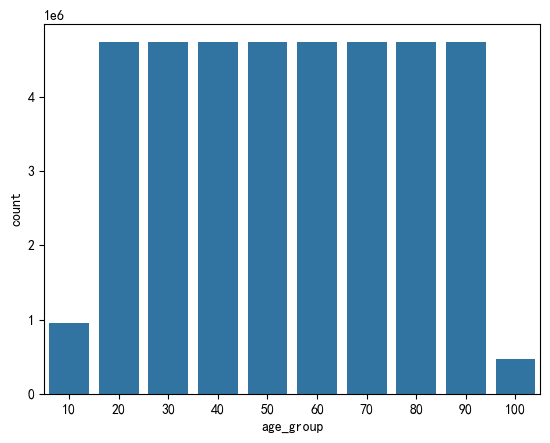

In [12]:
import seaborn as sns
import pyspark.sql.functions as F
age_dist = df.groupBy(
    (F.floor(F.col('age')/10)*10).alias('age_group')
).count().orderBy('age_group').toPandas()
sns.barplot(x='age_group', y='count', data=age_dist)

In [13]:
print("filter error age: now count:" + str(df.count()))
df = df.filter((F.col('age') >= 0) & (F.col('age') <= 120))
print("after filter count: " + str(df.count()))

filter error age: now count:39375000
after filter count: 39375000


# 性别-国家交叉热力图

<Axes: ylabel='gender'>

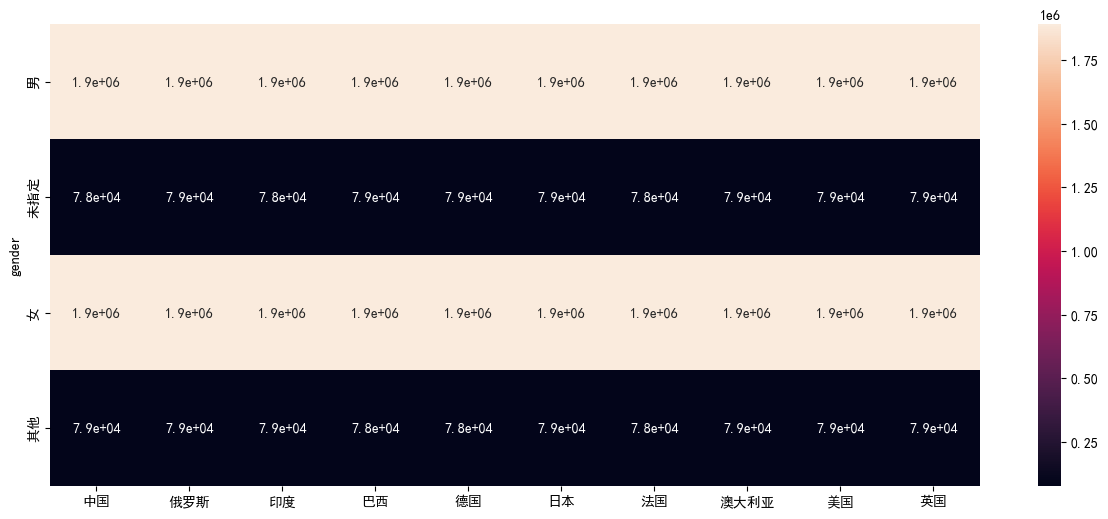

In [14]:
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

cross_tab = df.groupBy('gender').pivot('country').count().fillna(0)
plt.figure(figsize=(15,6))
sns.heatmap(cross_tab.toPandas().set_index('gender'), annot=True)

In [15]:
import pyspark.sql.functions as F
# 检查缺失值
missing_values = {}
for col_name in df.columns:
    missing_count = df.filter(F.col(col_name).isNull()).count()
    missing_ratio = missing_count / df.count()
    missing_values[col_name] = (missing_count, missing_ratio)
print("缺失值统计：")
for col_name, (count, ratio) in missing_values.items():
    print(f"{col_name}: 数量={count}, 比例={ratio:.2%}")

缺失值统计：
id: 数量=0, 比例=0.00%
last_login: 数量=0, 比例=0.00%
user_name: 数量=0, 比例=0.00%
fullname: 数量=0, 比例=0.00%
email: 数量=0, 比例=0.00%
age: 数量=0, 比例=0.00%
income: 数量=0, 比例=0.00%
gender: 数量=0, 比例=0.00%
country: 数量=0, 比例=0.00%
address: 数量=0, 比例=0.00%
purchase_history: 数量=0, 比例=0.00%
is_active: 数量=0, 比例=0.00%
registration_date: 数量=0, 比例=0.00%
phone_number: 数量=0, 比例=0.00%
login_history: 数量=0, 比例=0.00%


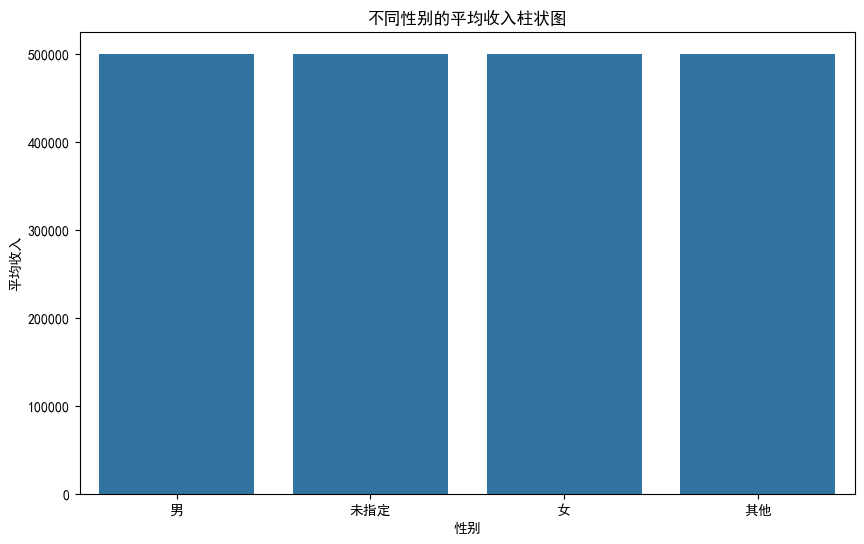

In [16]:
import seaborn as sns
# 2. 不同性别的平均收入柱状图
gender_income = df.groupBy("gender").avg("income").toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="avg(income)", data=gender_income)
plt.title("不同性别的平均收入柱状图")
plt.xlabel("性别")
plt.ylabel("平均收入")
plt.show()

In [ ]:
from pyspark.sql.functions import col, from_json, explode, when
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType

# 定义 JSON 结构
schema = StructType([
    StructField("avg_price", FloatType(), True),
    StructField("categories", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("id", IntegerType(), True)
    ])), True)
])

# 将 purchase_history 列从字符串解析为 JSON 格式
df = df.withColumn("purchase_history", from_json(col("purchase_history"), schema))

# 年龄分层
df = df.withColumn("age_group",
                   when(col("age") < 30, "青年")
                   .when((col("age") >= 30) & (col("age") < 60), "中年")
                   .when(col("age") >= 60, "老年")
                   )

# 收入分层
df = df.withColumn("income_group",
                   when(col("income") < 100000, "低收入")
                   .when((col("income") >= 100000) & (col("income") < 500000), "中等收入")
                   .when(col("income") >= 500000, "高收入")
                   )

# 购买类别
df = df.withColumn("purchase_category", col("purchase_history.categories"))

# 提取用户画像
user_profile = df.select("user_name", "age_group", "income_group", "gender", "country", "purchase_category")
user_profile.show()

+----------+---------+------------+------+--------+-----------------+
| user_name|age_group|income_group|gender| country|purchase_category|
+----------+---------+------------+------+--------+-----------------+
|RKWKCXRZFV|     老年|    中等收入|    女|    美国|             零食|
|    RCLELJ|     老年|      高收入|    男|    英国|             手套|
|     KSHSK|     中年|      高收入|    女|澳大利亚|             裙子|
|  CCJMXPJA|     青年|    中等收入|    男|    巴西|             耳机|
|   TJRJDNO|     老年|    中等收入|    男|    英国|             手套|
|   AKYKTTY|     中年|      高收入|    男|    德国|             帽子|
|     NOJMS|     中年|      高收入|    男|    中国|             水产|
|    BAJEZV|     老年|      高收入|    男|    日本|         智能手表|
|    LCODJG|     老年|    中等收入|    女|    日本|             音响|
|    WCBIXG|     老年|      高收入|    男|    印度|             玩具|
|BQBZHTZYOH|     老年|    中等收入|    女|    巴西|             水产|
|  BSWUYQGM|     老年|    中等收入|  其他|    德国|     儿童课外读物|
|NLMGMTEENY|     中年|      高收入|    女|  俄罗斯|             家具|
|MUIZDCLSIA|     青年|      

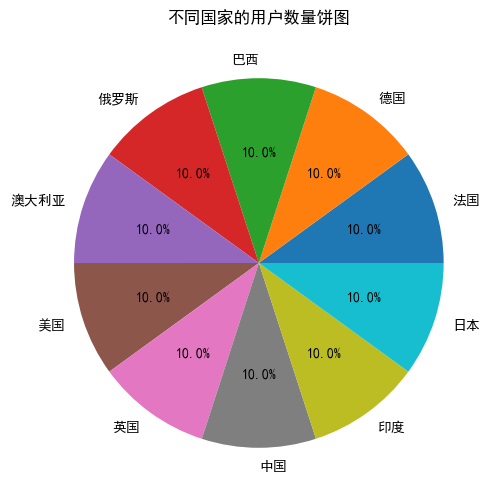

In [18]:
# 3. 不同国家的用户数量饼图
country_count = df.groupBy("country").count().toPandas()
plt.figure(figsize=(10, 6))
plt.pie(country_count["count"], labels=country_count["country"], autopct='%1.1f%%')
plt.title("不同国家的用户数量饼图")
plt.show()

In [19]:
purchase_hist = df.select('purchase_history')
purchase_hist.show(truncate=False)

+-----------------------------------------------------------+
|purchase_history                                           |
+-----------------------------------------------------------+
|{9496.0, 零食, [{7265}]}                                   |
|{3014.0, 手套, [{5245}]}                                   |
|{8921.0, 裙子, [{4020}]}                                   |
|{939.0, 耳机, [{1149}]}                                    |
|{959.0, 手套, [{506}, {5347}, {9601}]}                     |
|{5392.0, 帽子, [{4593}]}                                   |
|{738.0, 水产, [{1924}, {7330}]}                            |
|{4194.0, 智能手表, [{1461}, {7826}, {8220}, {2159}]}       |
|{631.0, 音响, [{5871}, {9395}]}                            |
|{6418.0, 玩具, [{5434}, {1842}]}                           |
|{5148.0, 水产, [{5283}]}                                   |
|{2844.0, 儿童课外读物, [{5914}, {206}, {6865}]}            |
|{7359.0, 家具, [{9991}]}                                   |
|{6439.0, 肉类, [{2464}, {4515}]}         

In [21]:
import matplotlib.pyplot as plt
import matplotlib
# 将 purchase_history 列从字符串解析为 JSON 格式
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType


df_hist = df.select('id', 'purchase_history')

exploded_df = df_hist.select(F.col("id"), F.col("purchase_history.avg_price"), F.col("purchase_history.categories"), F.explode(F.col("purchase_history.items")).alias("item"))

# 提取 item 中的 id
final_df = exploded_df.select(F.col("id"), F.col("avg_price"), F.col("categories"), F.col("item.id").alias("item_id"))

final_df.show()

+---+---------+------------+-------+
| id|avg_price|  categories|item_id|
+---+---------+------------+-------+
|  0|   9496.0|        零食|   7265|
|  1|   3014.0|        手套|   5245|
|  2|   8921.0|        裙子|   4020|
|  3|    939.0|        耳机|   1149|
|  4|    959.0|        手套|    506|
|  4|    959.0|        手套|   5347|
|  4|    959.0|        手套|   9601|
|  5|   5392.0|        帽子|   4593|
|  6|    738.0|        水产|   1924|
|  6|    738.0|        水产|   7330|
|  7|   4194.0|    智能手表|   1461|
|  7|   4194.0|    智能手表|   7826|
|  7|   4194.0|    智能手表|   8220|
|  7|   4194.0|    智能手表|   2159|
|  8|    631.0|        音响|   5871|
|  8|    631.0|        音响|   9395|
|  9|   6418.0|        玩具|   5434|
|  9|   6418.0|        玩具|   1842|
| 10|   5148.0|        水产|   5283|
| 11|   2844.0|儿童课外读物|   5914|
+---+---------+------------+-------+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import avg, count

# 计算每个类别的平均价格
category_avg_price = final_df.groupBy("categories") \
    .agg(avg("avg_price").alias("avg_price"))

category_avg_price.show()

# 计算每个类别下的商品数量
category_item_count = final_df.groupBy("categories") \
    .agg(count("item_id").alias("item_count"))

category_item_count.show()

+------------+------------------+
|  categories|         avg_price|
+------------+------------------+
|        手套| 5006.365929862324|
|      摄像机| 5007.983172756359|
|    益智玩具| 5005.734836445398|
|    床上用品| 5003.353412931898|
|        水产| 5009.062870963464|
|        肉类| 5004.600784908635|
|儿童课外读物| 5004.485724459407|
|        围巾| 5006.604098287251|
|    平板电脑| 5010.355915707996|
|        米面|5004.8142560797205|
|        蛋奶| 5002.531711410769|
|        内衣|5005.1932730118215|
|        上衣| 5005.502280385416|
|    车载电子| 5005.754398581102|
|        外套| 5007.284318181252|
|        模型| 5004.831715614092|
|        鞋子| 5005.233445885339|
|    汽车装饰| 5003.042266399895|
|        饮料| 5000.762669853163|
|        水果| 5003.530465241014|
+------------+------------------+
only showing top 20 rows

+------------+----------+
|  categories|item_count|
+------------+----------+
|        手套|   2816261|
|      摄像机|   2812047|
|    益智玩具|   2810835|
|    床上用品|   2811776|
|        水产|   2812777|
|        肉类|   28107

In [24]:
spark.catalog.clearCache()

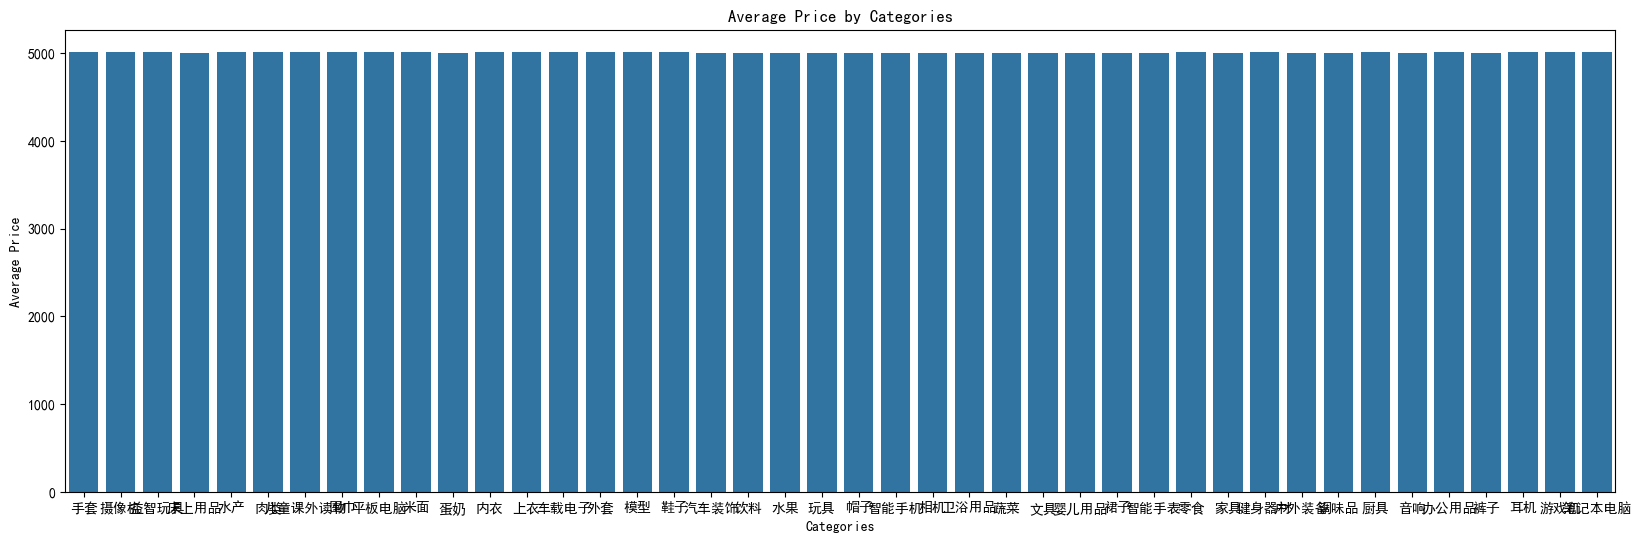

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 将结果转换为 Pandas DataFrame
category_avg_price_pd = category_avg_price.toPandas()

# 绘制柱状图
plt.figure(figsize=(20, 6))
sns.barplot(x="categories", y="avg_price", data=category_avg_price_pd)
plt.xlabel("Categories")
plt.ylabel("Average Price")
plt.title("Average Price by Categories")
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"程序运行时间: {elapsed_time} 秒")